In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master/')
import timm

In [2]:
from timm import create_model 
from fastai.vision.all import *

set_seed(42, reproducible=True)

In [3]:
!tree ../input -d

../input
├── petfinder-pawpularity-score
│   ├── test
│   └── train
├── swin-transformer
└── timm-pytorch-image-models
    └── pytorch-image-models-master
        ├── convert
        ├── docs
        │   ├── javascripts
        │   └── models
        ├── notebooks
        ├── results
        ├── tests
        └── timm
            ├── data
            │   └── parsers
            ├── loss
            ├── models
            │   ├── layers
            │   └── pruned
            ├── optim
            ├── scheduler
            └── utils

23 directories


In [4]:
train_imgs_path = '../input/petfinder-pawpularity-score/train/'
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')

In [5]:
def append_path(data, train=True):
    if train:
        return f'{train_imgs_path}{data}.jpg'
    else:
        return f'{test_imgs_path}{data}.jpg'

In [6]:
train_df['full_path'] = train_df['Id'].apply(lambda x: append_path(x))
train_df['norm_score'] = train_df['Pawpularity']/100
train_df.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,full_path,norm_score
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg,0.63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/0009c66b9439883ba2750fb825e1d7db.jpg,0.42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/0013fd999caf9a3efe1352ca1b0d937e.jpg,0.28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/0018df346ac9c1d8413cfcc888ca8246.jpg,0.15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001dc955e10590d3ca4673f034feeef2.jpg,0.72


In [7]:
dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader('full_path'),
                get_y=ColReader('norm_score'),
                splitter=RandomSplitter(0.2),
                item_tfms=Resize(450),
                batch_tfms=setup_aug_tfms([RandomResizedCrop(size=224), Flip(size=224)]),
               )

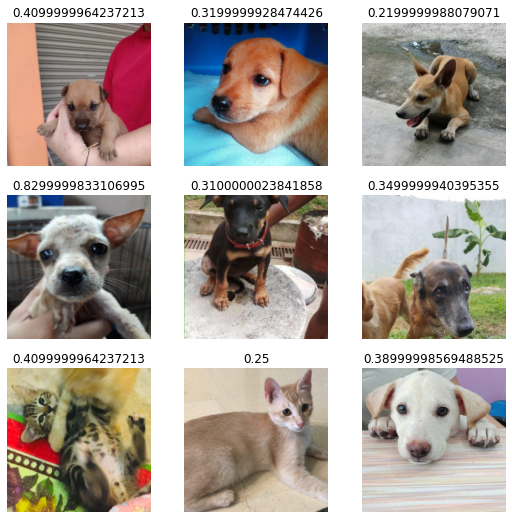

In [8]:
paw_dls = dls.dataloaders(train_df , batch_size= 32, seed=12)
paw_dls.show_batch()

In [9]:
len(paw_dls.train.dataset), len(paw_dls.valid.dataset)

(7930, 1982)

In [10]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [11]:
model = create_model('swin_large_patch4_window7_224', 
                     pretrained=True, 
                     num_classes=paw_dls.c)

In [12]:
def metric_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [13]:
learn = Learner(paw_dls, 
                model, 
                loss_func = BCEWithLogitsLossFlat(), 
                metrics = metric_rmse, 
                cbs=[MixUp(0.2)]).to_fp16()

SuggestedLRs(lr_min=0.0001454159850254655, lr_steep=2.9154431103961542e-05)

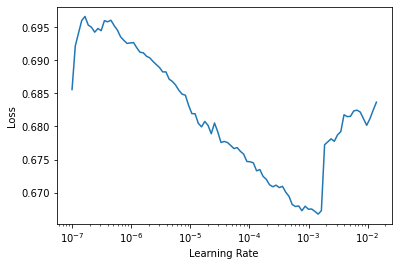

In [14]:
learn.lr_find(end_lr=3e-2)

In [15]:
learn.fit_one_cycle(6, 5.477225568029098e-05, cbs=[EarlyStoppingCallback(monitor='metric_rmse', 
                                               comp=np.less, 
                                               patience=3)])

epoch,train_loss,valid_loss,metric_rmse,time
0,0.651864,0.646472,18.007500,06:46
1,0.647190,0.645782,17.820417,06:44
2,0.642824,0.643182,17.615032,06:44
3,0.636289,0.644299,17.762817,06:44
4,0.629822,0.644576,17.652197,06:45
5,0.621565,0.643863,17.586496,06:44


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


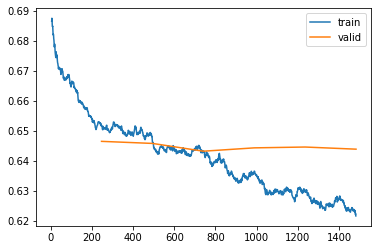

In [16]:
learn.recorder.plot_loss()

In [17]:
learn = learn.to_fp32()

In [18]:
learn.save('pawpular_model')
learn.export()

In [19]:
dataset_path = Path('../input/petfinder-pawpularity-score/')

In [20]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [21]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['full_path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100
test_dl = paw_dls.test_dl(test_df)

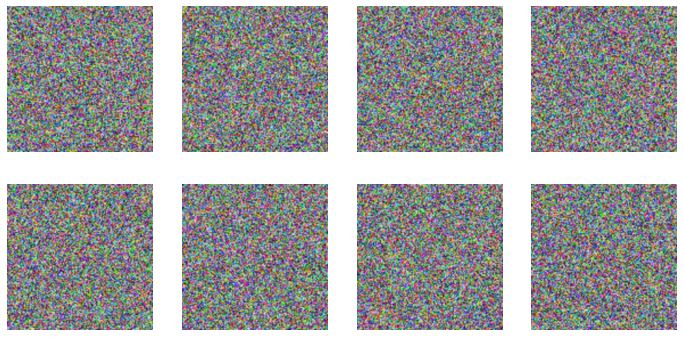

In [22]:
test_dl.show_batch()

In [23]:
preds, _ = learn.tta(dl=test_dl, n=10, beta=0)

In [24]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df['Pawpularity'] = preds.float().numpy()*100
sample_df.to_csv('submission.csv',index=False)